# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support, ndcg_score

from tqdm import tqdm

# Loading the Data

In [2]:
df_rv = pd.read_csv('../datasets/reviews-cleaned.csv')
df_rv.head()

,user,name,rating
0,1 Family Meeple,10 Days in Europe,4.1
1,1 Family Meeple,12 Days,7.0
2,1 Family Meeple,7 Wonders,6.5
3,1 Family Meeple,A Column of Fire,5.0
4,1 Family Meeple,A Feast for Odin,10.0


In [3]:
df_sim = pd.read_csv('../datasets/df_item_sim.csv')
# df_sim = pd.read_csv('../datasets/df_item_sim.zip', compression='zip')

df_sim = df_sim.set_index('name')
df_sim.head()

,"...and then, we held hands.",...und tschüss!,10 Days in Africa,10 Days in Asia,10 Days in Europe,10 Days in the Americas,10 Days in the USA,10 Minute Heist: The Wizard's Tower,10' to Kill,1000 Blank White Cards,...,Zooloretto Junior,Zooloretto: The Dice Game,Zoowaboo,Zug um Zug: Deutschland,Zulus on the Ramparts!: The Battle of Rorke's Drift – Second Edition,ZÈRTZ,[redacted],duck! duck! Go!,ebbes,iKNOW
name,,,,,,,,,,,,,,,,,,,,,
"...and then, we held hands.",1.000000,0.080115,0.158781,0.108188,0.140938,0.108727,0.127127,0.147714,0.141141,0.061741,...,0.075312,0.187834,0.076062,0.086458,0.098297,0.185706,0.165226,0.095863,0.127687,0.080030
...und tschüss!,0.080115,1.000000,0.164283,0.135121,0.228677,0.106158,0.131682,0.073456,0.054965,0.035974,...,0.121544,0.175149,0.139251,0.096781,0.034480,0.172880,0.065776,0.166939,0.199616,0.059040
10 Days in Africa,0.158781,0.164283,1.000000,0.584768,0.551947,0.481432,0.553647,0.096274,0.070299,0.134278,...,0.175300,0.268873,0.173794,0.063029,0.116536,0.336803,0.089493,0.284904,0.098230,0.087955
10 Days in Asia,0.108188,0.135121,0.584768,1.000000,0.541234,0.591203,0.509913,0.078295,0.052857,0.098025,...,0.157740,0.237408,0.146475,0.068021,0.094460,0.272813,0.054192,0.252753,0.079539,0.076176
10 Days in Europe,0.140938,0.228677,0.551947,0.541234,1.000000,0.474869,0.520611,0.148301,0.101523,0.097216,...,0.169539,0.290477,0.212485,0.097823,0.074929,0.338660,0.089756,0.235569,0.140514,0.147720


In [4]:
df_sim.shape

(4582, 4582)

# Item-Based Recommendation Pipeline

In [406]:
def create_user_profile(dict_rating, df_sim):
    df = pd.DataFrame(index=[0], columns=df_sim.columns)
    for key, value in dict_rating.items():
        df[key] = value
    
    df = df.T.fillna(0)
    df.rename(columns={0:'rating'}, inplace=True)

    return df

def recommend_games(df_new_user , df_sim):
    # Convert df_similarity and df_new_user to numpy arrays
    df_similarity_array = df_sim.to_numpy()
    df_new_user_array = df_new_user.to_numpy()

    # Calculate the dot product (weighted ratings)
    weighted_ratings = np.dot(df_similarity_array, df_new_user_array)

    # Normalize the ratings by dividing by the sum of similarities for each item
    sum_of_similarities = df_sim.sum(axis=1)
    normalized_ratings = weighted_ratings / sum_of_similarities[:, np.newaxis]

    # Min-max scaling to a 0-10 range
    min_score = np.min(normalized_ratings)
    max_score = np.max(normalized_ratings)
    normalized_ratings = 10 * (normalized_ratings - min_score) / (max_score - min_score)

    # Convert the result to a DataFrame
    recommended_games_df = pd.DataFrame(normalized_ratings, index=df_sim.index, columns=["score"])

    # Sort the recommended games in descending order
    top_recommendations = recommended_games_df.loc[df_new_user.index].sort_values(by="score", ascending=False)

    # Return the top recommendations as a DataFrame
    return top_recommendations

In [453]:
dict_rating = { 
                'Through the Ages: A New Story of Civilization': 10,
                '7 Wonders Duel': 9,
                'Codenames': 8,
                'Scythe':8,
                'Gizmos': 7.5,
                'Splendor': 7,
                'Black Stories': 6.5,
                'Dixit': 6,
                'One Night Ultimate Werewolf': 2,
                'Ultimate Werewolf: Deluxe Edition': 1, 
                'Ultimate Werewolf':1,
                }

# dict_rating = { 
#                 'Food Chain Magnate': 10,
#                 'Anachrony': 10,
#                 'Gaia Project': 10,
#                 'Everdell':10,
#                 'Brass: Birmingham': 10,
#                 'Nemesis': 10,
#                 'Ultimate Werewolf: Deluxe Edition': 1, 
#                 'Ultimate Werewolf':1,
#                 }

# dict_rating = { 
#                 'Kraftwagen': 8,
#                 'Gizmos': 7.5,
#                 'Love Letter':7,
#                 'Black Stories': 7
#                 }

In [454]:
df = pd.DataFrame(list(dict_rating.items()), columns=['name', 'rating'])

mean_value = df['rating'].mean()

# selected_rows = df[df['rating']>=9.5]
# rows_to_change = selected_rows.sample(n=5)
# df.loc[rows_to_change.index, 'rating'] = 0

dict_rating = dict(zip(df['name'], df['rating']))
df_new_user = create_user_profile(dict_rating, df_sim)
# df = df_new_user.copy()

condition = (df_new_user['rating'] < mean_value) & (df_new_user['rating'] != 0)  & (df_new_user['rating'] < 5)
df_new_user.loc[condition, 'rating'] -= mean_value

df_recommeds = recommend_games(df_new_user, df_sim)
rec_games = df_recommeds.loc[df_new_user[df_new_user.values == 0].index].sort_values(by="score", ascending=False)[:20]
rec_games 

,score
La Fallera Calavera,9.218300
Timeline: Polska,9.066873
Viticulture Essential Edition,8.995868
Alchemists,8.905498
Gaia Project,8.897179
Great Western Trail,8.800177
The Message,8.799519
Agricola (Revised Edition),8.751179
A Feast for Odin,8.736812
Terraforming Mars,8.713000


In [430]:
df_new_user.sort_values(by="rating", ascending=False)
# df_new_user

,rating
Kraftwagen,8.0
Gizmos,7.5
Love Letter,7.0
Black Stories,7.0
Raging Bulls,0.0
...,...
FlowerFall,0.0
Flowerpower,0.0
Flyin' Goblin,0.0
Flying Colors,0.0


# Evaluation

In [6]:
def evaluate_recommender(df_ground_truth, df_recommended):
    # Convert ground truth to a 2D array
    ground_truth_array = df_ground_truth.to_numpy()

    # Convert recommended scores to a 2D array
    recommended_scores_array = df_recommended.to_numpy()

    # Flatten the arrays if they are not already flattened
    ground_truth_array = ground_truth_array.flatten()
    recommended_scores_array = recommended_scores_array.flatten()

    # Calculate NDCG
    ndcg = ndcg_score([ground_truth_array], [recommended_scores_array])

    return ndcg

In [390]:
df_true = df_rv[df_rv['user']=='1 Family Meeple']
# df_true = df_rv[df_rv['user']=='zuzusdad']

df_true = df_true.drop(columns='user')
df_true.sort_values(by="rating", ascending=False)[:10]

,name,rating
112,Cottage Garden,10.0
4,A Feast for Odin,10.0
106,Concordia,10.0
403,Rajas of the Ganges,10.0
404,Rajas of the Ganges: The Dice Charmers,10.0
99,Coimbra,9.5
592,Yokohama,9.5
499,Terraforming Mars,9.5
413,Rococo,9.0
237,Heaven & Ale,9.0


In [403]:
df  = df_true.copy()

selected_rows = df_true[df_true['rating']>=9.5]
mean_value = df['rating'].mean()

rows_to_change = selected_rows.sample(n=5)
df.loc[rows_to_change.index, 'rating'] = 0
dict_rating = dict(zip(df['name'], df['rating']))

df_new_user = create_user_profile(dict_rating, df_sim)
df = df_new_user.copy()

condition = (df_new_user['rating'] < mean_value) & (df_new_user['rating'] != 0) & (df_new_user['rating'] < 5)

df_new_user.loc[condition, 'rating'] -= mean_value

df_recommeds = recommend_games(df_new_user, df_sim)
rec_games = df_recommeds.loc[df_new_user[df_new_user.values == 0].index].sort_values(by="score", ascending=False)[:10]

rated_games = df_true['name']
rated_games = [x for x in rated_games if x not in rows_to_change]

ndcg = evaluate_recommender(df['rating'], df_recommeds)

print(f"NDCG Score: {ndcg}")

NDCG Score: 0.6564395058206385


In [404]:
rows_to_change

,name,rating
592,Yokohama,9.5
499,Terraforming Mars,9.5
403,Rajas of the Ganges,10.0
4,A Feast for Odin,10.0
106,Concordia,10.0


In [405]:
rec_games = df_recommeds[~df_recommeds.isin(rated_games)].sort_values(by="score", ascending=False)[:20]
rec_games[rec_games.index.isin(rows_to_change['name'])]

,score
A Feast for Odin,8.981441
Rajas of the Ganges,8.969388
Yokohama,8.926524


In [330]:
rec_games[:20]

,score
OrganATTACK!,10.000000
Lorenzo il Magnifico,9.168404
Rajas of the Ganges,9.144295
Grand Austria Hotel,9.115000
Coimbra,9.104981
La Granja,9.082483
Viticulture Essential Edition,9.082449
Teotihuacan: City of Gods,9.081485
Vinhos Deluxe Edition,9.071807
Sheriff of Nottingham,9.047884


In [331]:
df_rv_rate = df_rv.set_index('user').copy()
df_rv_rate = df_rv_rate.groupby(['user', 'name']).mean()

# list of all users'name
all_users = list(df_rv_rate.index.get_level_values('user').unique())

# dataframe of all users 
df_users = df_rv_rate[df_rv_rate.index.get_level_values('user').isin(all_users)].copy()
df_users

rating
user            name                                  
1 Family Meeple 10 Days in Europe                  4.1
                12 Days                            7.0
                7 Wonders                          6.5
                A Column of Fire                   5.0
                A Feast for Odin                  10.0
...                                                ...
zuzusdad        Wreck Raiders                      9.2
                XCOM: The Board Game               8.4
                Xia: Legends of a Drift System     6.5
                Zombie Dice                        7.0
                Zooloretto                         9.9

[2018715 rows x 1 columns]

In [334]:
df_eval = pd.DataFrame()
ndcg_sum = 0
eval_users = all_users[:100]
for user in tqdm(eval_users):
  df = df_rv[df_rv['user']==user].drop(columns='user')
  dict_rating = dict(zip(df['name'], df['rating']))

  df_new_user = create_user_profile(dict_rating, df_sim)
  df_new_user.rename(columns={0:'rating'}, inplace=True)
  df = df_new_user.copy()

  condition = (df_new_user['rating'] < mean_value) & (df_new_user['rating'] != 0)
  df_new_user.loc[condition, 'rating'] -= mean_value

  df_recommeds = recommend_games(df_new_user, df_sim)

  ndcg = evaluate_recommender(df['rating'], df_recommeds)
  df_eval[user] = {'ndcg': f'{ndcg:.4f}', 'game_count': len(df)}
  ndcg_sum += ndcg
  
df_eval = df_eval.T
print(f"NDCG Score: {pd.to_numeric(df_eval['ndcg']).mean()}")

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]

NDCG Score: 0.675349


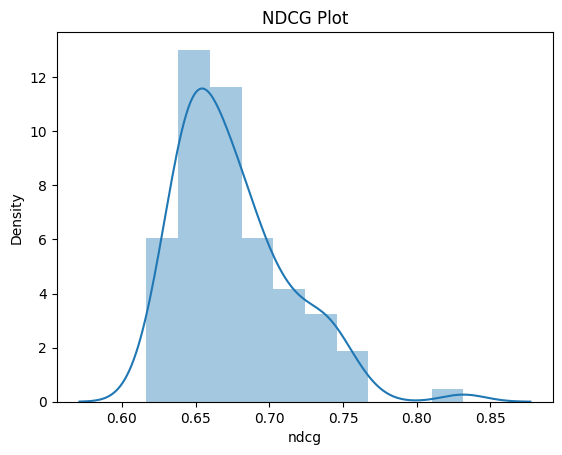

In [336]:
plt.title("NDCG Plot")
sns.distplot(df_eval['ndcg'])
plt.show()